# Arabic Sign Language Recognition using CNNs

## Introduction

This notebook details the implementation of a neural network using PyTorch to recognize Arabic Sign Language alphabets.  The goal is to contribute to improving accessibility and communication for those who use sign language.

## 1. Dataset Details: ArASL

This project utilizes the ArASL (Arabic Alphabets Sign Language Dataset).  This dataset contains images of hand signs representing the Arabic alphabet.

- **Total Images:** 54,049
- **Classes:** 32 (representing the Arabic alphabet)

## 2. Label Representation

Each image is associated with a numerical label representing a specific Arabic character.  These labels are integers ranging from 0 to 31.

## 3. Character Mapping

The mapping between numerical labels and corresponding Arabic characters is defined in the `mapping` variable (see code).  The mapping is also provided below for reference:

0: 'seen', 1: 'zay', 2: 'aleff', 3: 'dal', 4: 'ta', 5: 'yaa', 6: 'fa', 7: 'ya', 8: 'khaa', 9: 'nun', 10: 'ha', 11: 'toot', 12: 'taa', 13: 'ra', 14: 'kaaf', 15: 'jeem', 16: 'laam', 17: 'la', 18: 'dhad', 19: 'dha', 20: 'waw', 21: 'meem', 22: 'al', 23: 'sheen', 24: 'haa', 25: 'thaa', 26: 'saad', 27: 'ghain', 28: 'ain', 29: 'thal', 30: 'gaaf', 31: 'bb'

## 4. Reference

Latif, G., Mohammad, N., Alghazo, J., AlKhalaf, R., & AlKhalaf, R. (2019). ARASL: Arabic Alphabets Sign Language Dataset. *Data in Brief*, 23, 103777. https://doi.org/10.1016/j.dib.2019.103777

## 5. Instructions

Your task is to do the following:

1. **Classification Model:**
    * Design and implement a CNN architecture for classification.
    * Train the model using the `DataLoaders`.
    * Evaluate the model and show the results.
2. **Autoencoder:**
    * Design and implement a CNN-based autoencoder (encoder-decoder).
    * Train the autoencoder using the `DataLoader`.
    * Evaluate the model and show the results.


In [ ]:
from IPython.display import clear_output

In [ ]:
# Download the required libraries (needed when running outside colab where the environment doesn't come pre-loaded with libraries)

# %pip install torch
# %pip install torchvision
# %pip install matplotlib

# clear_output()

In [ ]:
# importing libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms.functional import to_tensor, to_pil_image, resize
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt

## Downloading the dataset

### Run the following cells to download the ArASL dataset.

In [ ]:
!gdown https://data.mendeley.com/public-files/datasets/y7pckrw6z2/files/1efa0d6b-4d7f-4f58-9584-08f0488279ee/file_downloaded

Downloading...
From: https://data.mendeley.com/public-files/datasets/y7pckrw6z2/files/1efa0d6b-4d7f-4f58-9584-08f0488279ee/file_downloaded
To: /content/file_downloaded
100% 66.2M/66.2M [00:02<00:00, 25.6MB/s]


In [ ]:
!unzip file_downloaded
clear_output()

## Just run these two cells. You are not supposed to explore them.

In [ ]:
import os

def rename_folders_and_create_mapping(folder_path):
    # Get the list of folders in the specified path
    folders = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

    # Create a mapping from original folder names to numbers
    folder_mapping = {folder: i for i, folder in enumerate(folders)}

    # Rename the folders in-place and store the original names in the mapping
    for original_folder, number in folder_mapping.items():
        new_folder_name = str(number)
        new_folder_path = os.path.join(folder_path, new_folder_name)

        # Rename the folder
        os.rename(os.path.join(folder_path, original_folder), new_folder_path)

    return folder_mapping

folder_path = 'ArASL_Database_54K_Final'

# Create the folder mapping and rename folders
mapping = rename_folders_and_create_mapping(folder_path)

# Print the folder mapping
print("Folder Mapping:")
print(mapping)


Folder Mapping:
{'meem': 0, 'gaaf': 1, 'dal': 2, 'sheen': 3, 'dha': 4, 'ra': 5, 'ghain': 6, 'aleff': 7, 'laam': 8, 'ya': 9, 'saad': 10, 'thal': 11, 'yaa': 12, 'zay': 13, 'dhad': 14, 'al': 15, 'seen': 16, 'toot': 17, 'kaaf': 18, 'bb': 19, 'la': 20, 'khaa': 21, 'thaa': 22, 'ha': 23, 'nun': 24, 'jeem': 25, 'waw': 26, 'ain': 27, 'taa': 28, 'fa': 29, 'ta': 30, 'haa': 31}


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, root_folder, transform=None, target_size=(28, 28)):
        self.root_folder = root_folder
        self.transform = transform
        self.target_size = target_size

        # Get the list of image files
        self.image_files = []
        self.image_labels = []

        for root, dirs, files in os.walk(root_folder):
            for file in files:
                if file.lower().endswith('.jpg'):
                    self.image_files.append(os.path.join(root, file))
                    self.image_labels.append(int(os.path.basename(root)))

    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label = self.image_labels[idx]

        # Convert label to tensor
        # print("Label", label, type(label))
        label = torch.tensor(label)

        # Open the image
        with Image.open(img_path) as img:
            # Convert the image to grayscale
            img = img.convert('L')

            # Resize the image
            img = img.resize(self.target_size)

            # Apply additional transformations if specified
            if self.transform:
                img = self.transform(img)

            return (img, label)

# Define the root folder and output folder
root_folder_path = 'ArASL_Database_54K_Final'


# Define transformations (resize to 28x28 and convert to tensor)
data_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
])

# Create an instance of the custom dataset
custom_dataset = CustomDataset(root_folder_path, transform=data_transform)

from torch.utils.data import random_split

# Define the size of the training and validation sets
total_size = len(custom_dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = total_size - train_size  # 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])

mapping = {v:k for k,v in mapping.items()}

## Exploring the data

#### Here is the mapping for each class and its encoding. In addition to the train_dataset and val_dataset

In [ ]:
train_dataset # Contains the training ArASL_Database_54K_Final dataset (80%)

val_dataset  # Contains the validating ArASL_Database_54K_Final dataset (20%)


print("The mapping between the letters and the encoding: \n", mapping)
print('Length of train_dataset is', len(train_dataset))
print('Length of val_dataset is'  , len(val_dataset))

The mapping between the letters and the encoding: 
 {0: 'meem', 1: 'gaaf', 2: 'dal', 3: 'sheen', 4: 'dha', 5: 'ra', 6: 'ghain', 7: 'aleff', 8: 'laam', 9: 'ya', 10: 'saad', 11: 'thal', 12: 'yaa', 13: 'zay', 14: 'dhad', 15: 'al', 16: 'seen', 17: 'toot', 18: 'kaaf', 19: 'bb', 20: 'la', 21: 'khaa', 22: 'thaa', 23: 'ha', 24: 'nun', 25: 'jeem', 26: 'waw', 27: 'ain', 28: 'taa', 29: 'fa', 30: 'ta', 31: 'haa'}
Length of train_dataset is 43239
Length of val_dataset is 10810


In [ ]:
batch_size = 64

# DataLoaders simplify the job of grouping the samples into batches.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # no need to shuffle validation data

## Let's visualize an image and its channels

The image shape: torch.Size([1, 48, 48])
Number of channels in image:  1
The image label: 6 ghain


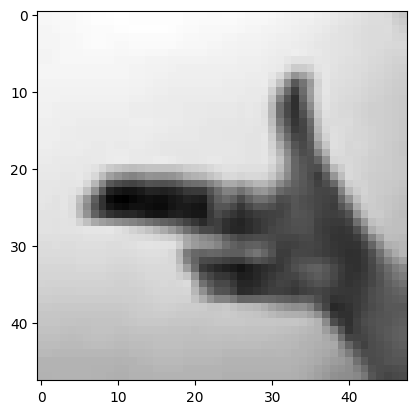

In [ ]:
random_img_idx = 30 # Write any random index (between 0 and 59999)

image = train_dataset[random_img_idx][0]  # 0 for image part in (image, label) tuple.
label = train_dataset[random_img_idx][1]  # 1 for label part

print("The image shape:", image.shape)
print('Number of channels in image: ', image.shape[0]) # 1 channel (layer) for black-white images.
print("The image label:", label.item(), mapping[label.item()])

plt.imshow(image.reshape(48, 48), cmap='gray')

### Create a loop to show 10 different images ranodmly

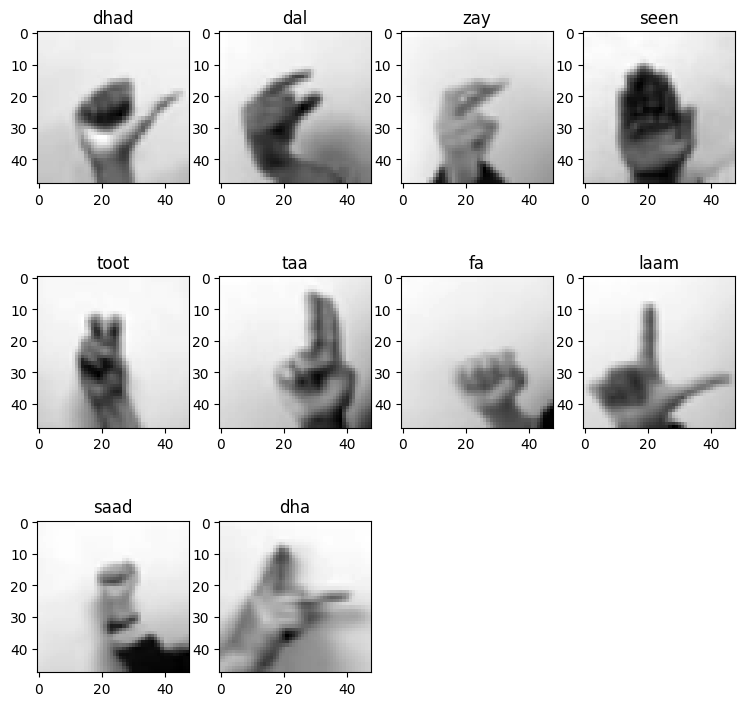

In [ ]:
import random

# create figure
fig = plt.figure(figsize=(9, 9))

for i in range(10):
    random_img_idx = random.randint(0, 43238) # Write any random index (between 0 and 43238)

    image = train_dataset[random_img_idx][0]  # 0 for image part in (image, label) tuple.
    label = train_dataset[random_img_idx][1]  # 1 for label part

    # Adds a subplot at the 2nd position
    fig.add_subplot(3, 4, i+1)
    plt.title(mapping[label.item()])
    plt.imshow(image.reshape(48, 48), cmap='gray')

In [ ]:
import torch.nn as nn

# Define Autoencoder Model
class CNNAutoEncoder(nn.Module):
    def __init__(self, encoding_dim=8):
        super(CNNAutoEncoder, self).__init__()

        # Encoder (Feature Extraction)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2, 1),  # (28x28) → (14x14)
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, 3, 2, 1), # (14x14) → (7x7)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Flatten(),  # Flatten to vector
            nn.Linear(32 * 12 * 12, encoding_dim),
            nn.BatchNorm1d(encoding_dim),
            nn.Tanh(),
        )

        # Decoder (Reconstruction)
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32 * 12 * 12),
            nn.BatchNorm1d(32 * 12 * 12),
            nn.LeakyReLU(),
            nn.Unflatten(1, (32, 12, 12)),  # Reshape back
            nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding=1),  # (7x7) → (14x14)
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 1, 3, 2, 1, output_padding=1),  # (14x14) → (28x28)
            nn.Sigmoid(),  # Normalize pixel values
        )

    def forward(self, x):
        encoder_out = self.encoder(x)
        decoder_out = self.decoder(encoder_out)
        return encoder_out, decoder_out

In [ ]:
from tqdm import tqdm    # Shows progress bar

# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    total_loss = 0

    for images, _ in tqdm(dataloader):  # Ignore labels since Autoencoders don't use them
        images = images.to(device)

        _, reconstructions = model(images)  # Forward pass (encoder + decoder)
        loss = criterion(reconstructions, images)  # Compute reconstruction loss

        optimizer.zero_grad()  # Reset gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss  # No accuracy since it's not classification


In [ ]:
import torch.optim as optim

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNAutoEncoder(encoding_dim=32).to(device)

# Print model summary
print(model)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Measure reconstruction quality
optimizer = optim.AdamW(model.parameters(), lr=1e-4)  # AdamW optimizer
num_epochs = 20 # Number of epochs

# Store losses for plotting
train_losses = []

# Training loop
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss = {train_loss:.4f}")

CNNAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=4608, out_features=32, bias=True)
    (8): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=4608, bias=True)
    (1): BatchNorm1d(4608, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Unflatten(dim=1, unflattened_size=(32, 12, 12))
    (4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 

100%|██████████| 676/676 [00:23<00:00, 29.15it/s]


Epoch 1/20, Loss = 0.0299


100%|██████████| 676/676 [00:23<00:00, 29.08it/s]


Epoch 2/20, Loss = 0.0103


100%|██████████| 676/676 [00:22<00:00, 30.07it/s]


Epoch 3/20, Loss = 0.0073


100%|██████████| 676/676 [00:23<00:00, 29.17it/s]


Epoch 4/20, Loss = 0.0062


100%|██████████| 676/676 [00:23<00:00, 29.25it/s]


Epoch 5/20, Loss = 0.0056


100%|██████████| 676/676 [00:23<00:00, 29.07it/s]


Epoch 6/20, Loss = 0.0052


100%|██████████| 676/676 [00:23<00:00, 29.24it/s]


Epoch 7/20, Loss = 0.0048


100%|██████████| 676/676 [00:23<00:00, 29.21it/s]


Epoch 8/20, Loss = 0.0045


100%|██████████| 676/676 [00:23<00:00, 29.01it/s]


Epoch 9/20, Loss = 0.0043


100%|██████████| 676/676 [00:22<00:00, 29.89it/s]


Epoch 10/20, Loss = 0.0042


100%|██████████| 676/676 [00:22<00:00, 29.49it/s]


Epoch 11/20, Loss = 0.0040


100%|██████████| 676/676 [00:23<00:00, 29.10it/s]


Epoch 12/20, Loss = 0.0039


100%|██████████| 676/676 [00:22<00:00, 29.41it/s]


Epoch 13/20, Loss = 0.0038


100%|██████████| 676/676 [00:23<00:00, 29.35it/s]


Epoch 14/20, Loss = 0.0036


100%|██████████| 676/676 [00:23<00:00, 29.16it/s]


Epoch 15/20, Loss = 0.0036


100%|██████████| 676/676 [00:23<00:00, 29.11it/s]


Epoch 16/20, Loss = 0.0035


100%|██████████| 676/676 [00:22<00:00, 29.65it/s]


Epoch 17/20, Loss = 0.0034


100%|██████████| 676/676 [00:22<00:00, 29.76it/s]


Epoch 18/20, Loss = 0.0033


100%|██████████| 676/676 [00:23<00:00, 29.06it/s]


Epoch 19/20, Loss = 0.0032


100%|██████████| 676/676 [00:23<00:00, 29.10it/s]

Epoch 20/20, Loss = 0.0032


### Plot loss and some predictions

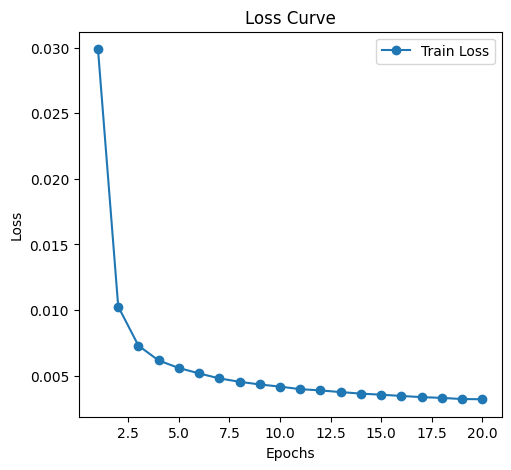

In [ ]:
import matplotlib.pyplot as plt

# Plot loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.show()

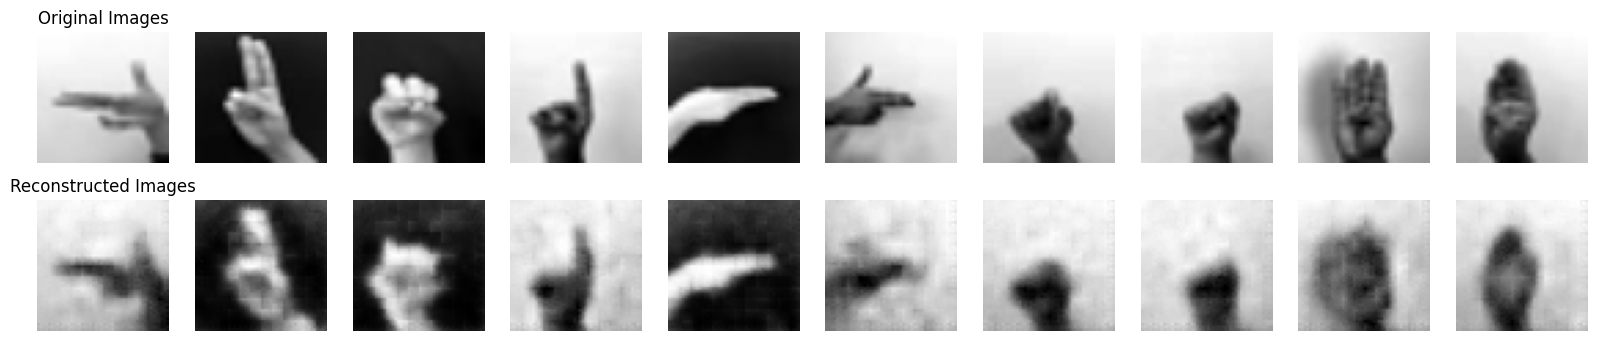

In [ ]:
import matplotlib.pyplot as plt

# 🔹 Function to Display Original vs. Reconstructed Images
def show_original_vs_reconstructed(model, dataloader, device, num_images=10):
    model.eval()  # Set to evaluation mode

    # Get a batch of images
    images, _ = next(iter(dataloader))
    images = images[:num_images].to(device)  # Select 'num_images' samples

    # Get reconstructed images
    with torch.no_grad():
        _, reconstructions = model(images)
    reconstructions = reconstructions.cpu()

    # Plot original vs reconstructed images
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

    for i in range(num_images):
        # Original images (Top row)
        axes[0, i].imshow(images[i].cpu().squeeze(), cmap="gray")
        axes[0, i].axis("off")

        # Reconstructed images (Bottom row)
        axes[1, i].imshow(reconstructions[i].squeeze(), cmap="gray")
        axes[1, i].axis("off")

    axes[0, 0].set_title("Original Images", fontsize=12)
    axes[1, 0].set_title("Reconstructed Images", fontsize=12)
    plt.show()

# 🔹 Display Results
show_original_vs_reconstructed(model, train_loader, device)


Let's generate some images:

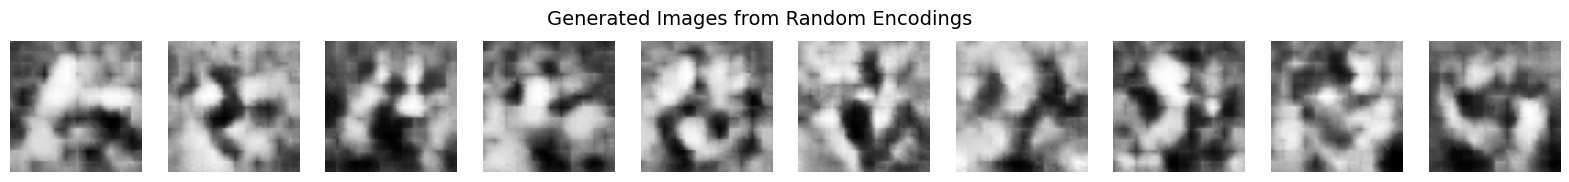

In [ ]:
import matplotlib.pyplot as plt

# 🔹 Function to Generate Images
def generate_images(model, num_images=10, encoding_dim=8):
    model.eval()  # Set to evaluation mode

    # Generate random encodings from a uniform distribution in [-1,1]
    random_encodings = (torch.rand(num_images, encoding_dim).to(device) - 0.5) * 2

    # Pass through decoder to generate images
    with torch.no_grad():
        generated_images = model.decoder(random_encodings).cpu()

    # Reshape images
    generated_images = generated_images.view(-1, 48, 48)  # Convert to 2D shape

    # Plot generated images
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i], cmap="gray")
        ax.axis("off")

    plt.suptitle("Generated Images from Random Encodings", fontsize=14)
    plt.show()

# 🔹 Generate & Display Images
generate_images(model, num_images=10, encoding_dim=32)


This challenge is made by [Hassan Alsayhah](https://www.linkedin.com/in/hassan-alsayhah-28a83a251/) & [Ali Alqutayfi](https://www.linkedin.com/in/ali-alqutayfi/)